In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def count_mass(p, triple):
    m = np.eye(3)
    m[0][0] = triple[0][0]
    m[0][1] = triple[1][0]
    m[0][2] = triple[2][0]
    m[1][0] = triple[0][1]
    m[1][1] = triple[1][1]
    m[1][2] = triple[2][1]
    m[2] = np.ones(3)
    b = np.array([p[0], p[1], 1])
    return np.linalg.inv(m) @ b

In [3]:
def is_inside(p, p1, p2, p3):
    try:
        mass = count_mass(p, [p1, p2, p3])
    except:
        return False
    return np.all(0 <= mass) and np.all(mass <= 1)

In [4]:
def get_ordered_list(l, point):
    l_copy = l.tolist()
    l_copy.sort(key = lambda p: (p[0] - point[0])**2 + (p[1] - point[1])**2)
    return l_copy

In [5]:
# если треугольника не нашлось, возвращает None
def find_triangle(l, point):
    ord_l = l.tolist()
    ord_l.sort(key = lambda p: (p[0] - point[0])**2 + (p[1] - point[1])**2)
    arr = [(p[0] - point[0])**2 + (p[1] - point[1])**2 for p in l]
    args = np.argsort(arr)
    for index_3 in range(2, len(l)):
        for index_1 in range(0, index_3):
            for index_2 in range(index_1, index_3):
                if is_inside(point, ord_l[index_1], ord_l[index_2], ord_l[index_3]):
                    return [args[index_1], args[index_2], args[index_3]]
    return None

In [6]:
#собственно функция построения образов по эталонным парам
def f(X, Y, point):
    neighbors_index = find_triangle(X, point)
    if neighbors_index is None:
        return None, None
    m1, m2, m3 = count_mass(point, X[neighbors_index])
    a, b, c = Y[neighbors_index]
    return tuple(map(sum, zip(a * m1, b * m2, c * m3))), neighbors_index

Протестируем функцию на рандомно сгенерированных множествах. Синие точки - эталонные, они поворачиваются на $10^{\circ}$. Образы красных точек получаем с помощью функции f по синим точкам.

In [7]:
size = 300
N = 50

rng = np.random.default_rng()
base_points = rng.integers(low=30, high=size, size=(N, 2))
test_points = rng.integers(low=50, high=size - 20, size=(N // 5, 2))

In [8]:
theta = np.radians(10)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

rotated_base_points = (R @ base_points.T).T

rotated_base_points = rotated_base_points * [1, 0.7]

rotated_base_points = np.array(np.round_(rotated_base_points), dtype='int')

In [9]:
def draw_triangle(img, points, indexes):
    p1 = points[indexes[0]]
    p2 = points[indexes[1]]
    p3 = points[indexes[2]]
    cv.line(img,p1,p2,(0,255,0),1)
    cv.line(img,p1,p3,(0,255,0),1)
    cv.line(img,p2,p3,(0,255,0),1)

In [10]:
img = np.ones((size,size,3), dtype=np.uint8) * 255
rotated_img = np.ones((size,size,3), dtype=np.uint8) * 255

for point in base_points:
    cv.circle(img, (point[0],point[1]), radius=3, color=(0, 0, 255), thickness=-1)
    
for point in rotated_base_points:
    cv.circle(rotated_img, (point[0],point[1]), radius=3, color=(0, 0, 255), thickness=-1)

for point in test_points:
    cv.circle(img, (point[0],point[1]), radius=3, color=(255, 0, 0), thickness=-1)


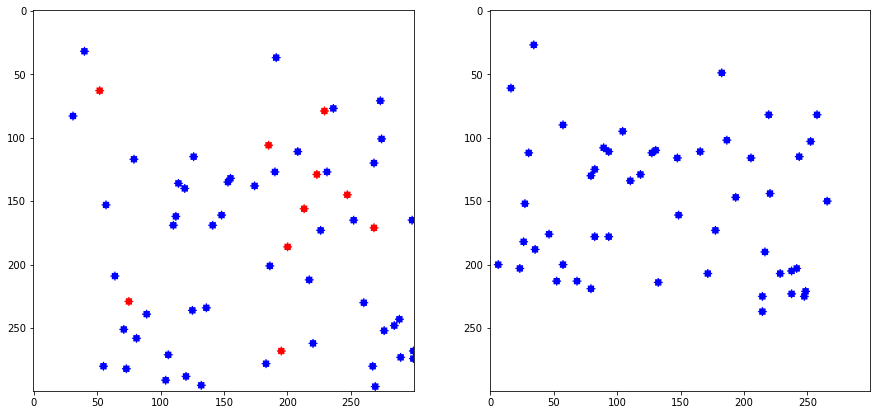

In [11]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 8))
axarr[0].imshow(img)
axarr[1].imshow(rotated_img)

In [12]:
test_points_f = []
triangle_neighbours = []

for test_point in test_points:
    test_point_f, neighbours = f(base_points, rotated_base_points, test_point)
    test_points_f.append(test_point_f)
    triangle_neighbours.append(neighbours)

img = np.ones((size,size,3), dtype=np.uint8) * 255
rotated_img = np.ones((size,size,3), dtype=np.uint8) * 255

for point in base_points:
    cv.circle(img, (point[0],point[1]), radius=3, color=(0, 0, 255), thickness=-1)
    
for point in rotated_base_points:
    cv.circle(rotated_img, (point[0],point[1]), radius=3, color=(0, 0, 255), thickness=-1)

for point, neighbours in zip(test_points, triangle_neighbours):
    cv.circle(img, (point[0],point[1]), radius=3, color=(255, 0, 0), thickness=-1)
    draw_triangle(img, base_points, neighbours)

for point, neighbours in zip(test_points_f, triangle_neighbours):    
    cv.circle(rotated_img, (int(point[0]),int(point[1])), radius=3, color=(255, 127, 0), thickness=-1)
    draw_triangle(rotated_img, rotated_base_points, neighbours)

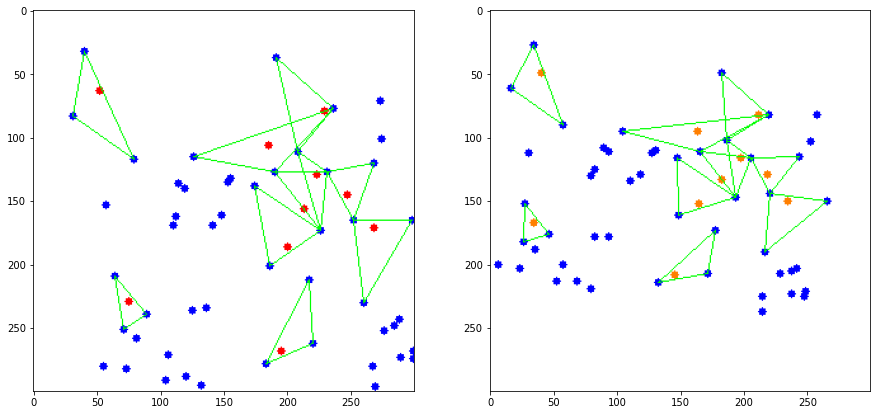

In [13]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 8))
axarr[0].imshow(img)
axarr[1].imshow(rotated_img)

$\vec{p} = m_1 \vec{r}_1 + m_2 \vec{r}_2 + m_3 \vec{r}_3$

$m_1 + m_2 + m_3 = 1$

$f(\vec{p}) = m_1 f(\vec{r}_1) + m_2 f(\vec{r}_2) + m_3 f(\vec{r}_3)$

$f$ - аффинное преобразование

_Комментарий._ Видим, что образы соотвестствуют реальному преобразованию, значит функция работает корректно.

Теперь запустим функцию на картинках _origin.jpg_ и _rec.jpg_. Эталонные соответствия находятся в файле _dot_pairs.csv_ Для примера будем работать не со всеми найденными парами, а только с N = 20 у которых наименьший distance.

Загрузим эталонные соответствия из файла и построим образы найденных sift-ом точек на _origin.jpg_

In [14]:
import pandas as pd

data = pd.read_csv('dot_pairs.csv')
data.head()

,x1,y1,x2,y2
0,37,79,38,156
1,36,212,38,411
2,142,79,259,153
3,116,213,208,410
4,247,54,480,97


In [15]:
X = []
Y = []

for i, row in data.iterrows():
    X.append([row['x1'], row['y1']])
    Y.append([row['x2'], row['y2']])

X = np.array(X)
Y = np.array(Y)

Посмотрим на эталонные точки:

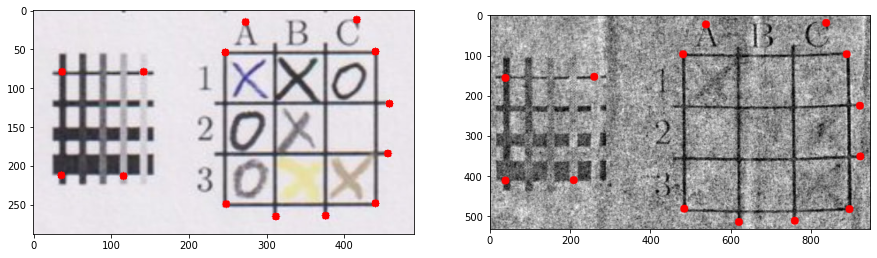

In [16]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 8))

img_1 = cv.imread("origin.jpg")
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)

for p in X:
    cv.circle(img_1, p, 5, (255, 0, 0), -1)

axarr[0].imshow(img_1)

img_2 = 255 - cv.imread("rec.jpg")
img_2 = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)

for p in Y:
    cv.circle(img_2, p, 10, (255, 0, 0), -1)

axarr[1].imshow(img_2)

Наконец построим образы точек, найденных sift-ом и посмотрим, насколько они близки к сопоставленным им точкам.

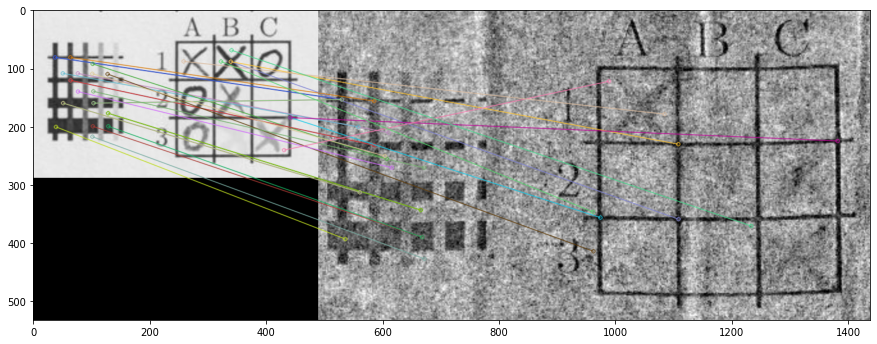

(<matplotlib.image.AxesImage at 0x332645630>, None)

In [230]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('origin.jpg', cv.IMREAD_GRAYSCALE)
img2 = 255 - cv.imread('rec.jpg', cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create(sigma=6.6, nOctaveLayers=2, edgeThreshold=500)

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher()

matches = bf.match(des1,des2)

matches = sorted(matches, key = lambda x:x.distance)
pairs = [ (kp1[match.queryIdx].pt, kp2[match.trainIdx].pt) for match in matches ]

N = 30

img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:N],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize =(15, 8)) 
    
plt.imshow(img3),plt.show()

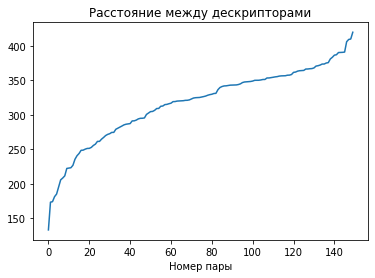

In [227]:
dist = [x.distance for x in matches]

plt.plot(dist)
plt.title('Расстояние между дескрипторами')
plt.xlabel('Номер пары')
plt.show()

In [148]:
keypoints_x = [ pair[0] for pair in pairs[:N] ]
keypoints_y = [ pair[1] for pair in pairs[:N] ]

keypoints_x_im = []
for point in keypoints_x:
    p, _ = f(X, Y, point)
    keypoints_x_im.append(p)

In [192]:
def get_color(mist):
    c_true = np.array([0, 255, 0])
    c_false = np.array([255,0,0])
    k = mist / 100
    k = min(k, 1)
    a, b, c = c_true * (1 - k) + k * c_false
    return (int(a), int(b), int(c))

get_color(0)

(0, 255, 0)

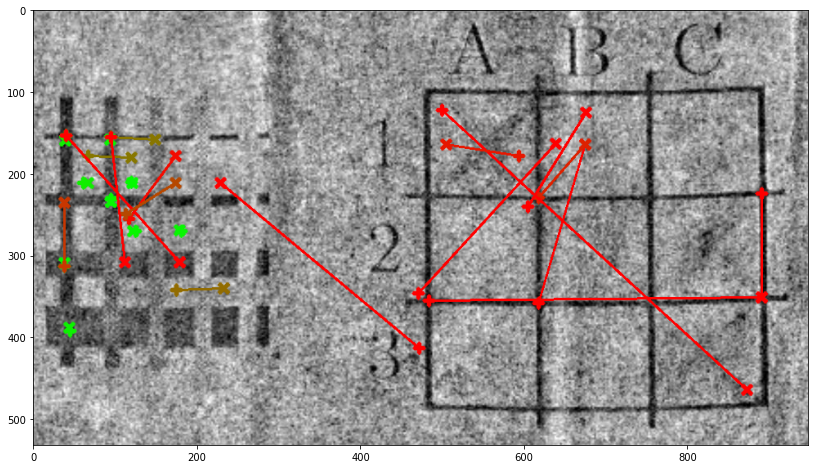

In [194]:
from PIL import Image

img_2 = 255 - cv.imread("rec.jpg")

M = 30

for p, true_p in zip(keypoints_y[:M], keypoints_x_im[:M]):
    if true_p is None:
        continue
    round_p = (int(p[0]), int(p[1]))
    round_true_p = (int(true_p[0]), int(true_p[1]))
    
    curr_mist = np.linalg.norm(np.array(p) - np.array(true_p))
    color = get_color(curr_mist)

    cv.drawMarker(img_2, round_p, color=color, thickness=3,
        markerType= cv.MARKER_CROSS, line_type=cv.LINE_AA, markerSize=12)
    cv.drawMarker(img_2, round_true_p, color=color, thickness=3,
        markerType= cv.MARKER_TILTED_CROSS, line_type=cv.LINE_AA, markerSize=10)
    cv.line(img_2,round_p,round_true_p,color,2)

plt.figure(figsize =(15, 8)) 
img = Image.fromarray(img_2)
plt.imshow(img_2)

На картинке выше красным изображены точки, полученные sift-ом на картинке _rec.jpg_, а зелёным - образы первых элементов из их пар, полученные на основе эталонных соответствий с помощью функции f.

В качестве ошибки возьмем евклидово расстояние между особой точкой на втором изображении и образом её пары (длина жёлтой линии между красным и зелёным крестиком).

In [123]:
mist = []
vec_mist = np.array([0, 0], dtype='float')

for p, true_p in zip(keypoints_y, keypoints_x_im):
    if true_p is None:
        continue
    vec_mist += (np.array(p) - np.array(true_p))
    mist.append(np.linalg.norm(np.array(p) - np.array(true_p)))

vec_mist /= N

Помимо обыкновенной была посчитана средняя векторная ошибка (сумма всех $\vec{p} - \vec{p}_{true}$, делённая на N)

Соотвественно можно утверждать, что систематического отклонения в какую-то сторону нет, так как размеры самого изображения как минимум в 25 раз превосходят среднюю векторную ошибку.

Построим график средней ошибки на первых $n$ лучших по близости дескрипторов парах в зависимости от $n$.

In [22]:
def get_mist(sigma, N, X, Y):
    img1 = cv.imread('origin.jpg', cv.IMREAD_GRAYSCALE)
    img2 = 255 - cv.imread('rec.jpg', cv.IMREAD_GRAYSCALE)

    sift = cv.SIFT_create(sigma=sigma, nOctaveLayers=3)

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    bf = cv.BFMatcher()

    matches = bf.match(des1,des2)

    matches = sorted(matches, key = lambda x:x.distance)
    pairs = [ (kp1[match.queryIdx].pt, kp2[match.trainIdx].pt) for match in matches ]
    
    keypoints_x = [ pair[0] for pair in pairs[:N] ]
    keypoints_y = [ pair[1] for pair in pairs[:N] ]

    keypoints_x_im = []
    for point in keypoints_x:
        x_im, _ = f(X, Y, point)
        keypoints_x_im.append(x_im)
        
    mist = []

    for p, true_p in zip(keypoints_y, keypoints_x_im):
        if true_p is None:
            continue
        mist.append(np.linalg.norm(np.array(p) - np.array(true_p)))
    return mist

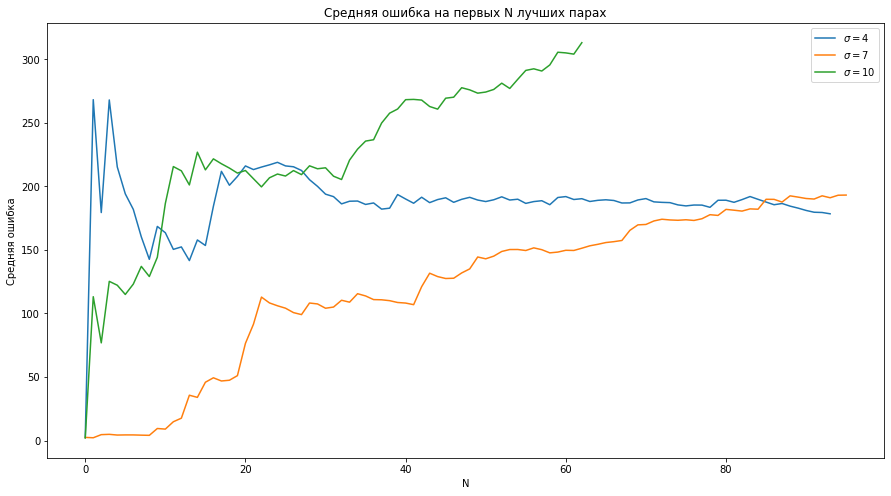

In [23]:
sigmas = [4, 7, 10]
legend = []

plt.figure(figsize=(15, 8)) 
for sigma in sigmas:
    mist = get_mist(sigma, 100, X, Y)
    cum_av_mist = np.cumsum(mist) / (np.arange(len(mist)) + 1)
    legend.append(fr"$\sigma=${sigma}")
    plt.plot(cum_av_mist)
    
plt.xlabel('N')
plt.ylabel('Средняя ошибка')
plt.title('Средняя ошибка на первых N лучших парах')
plt.legend(legend)
plt.show()

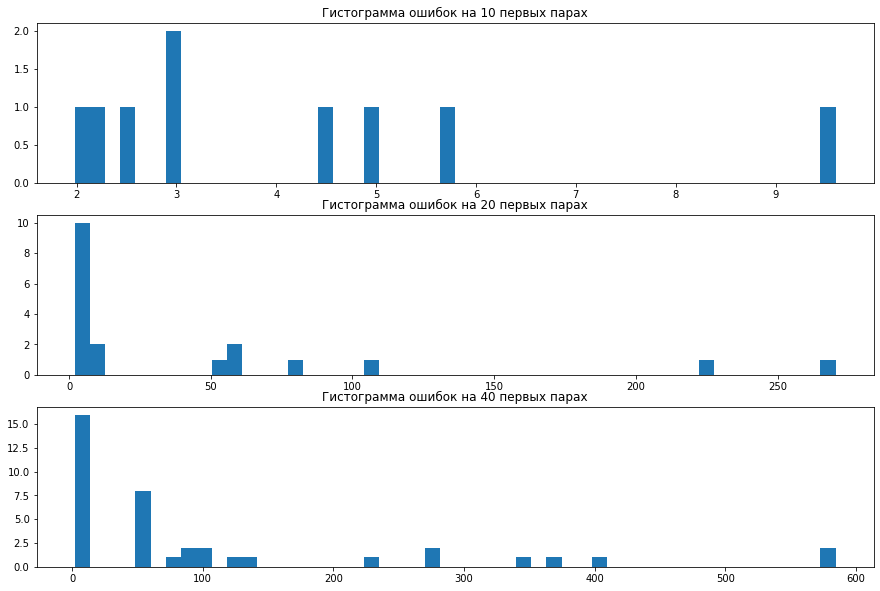

<Figure size 1080x1080 with 0 Axes>

In [222]:
fig, axarr = plt.subplots(3, 1, figsize=(15, 10))

mist_10 = np.array(get_mist(7, 10, X, Y))
mist_20 = np.array(get_mist(7, 20, X, Y))
mist_40 = np.array(get_mist(7, 40, X, Y))

plt.figure(figsize=(15, 15))

axarr[0].hist(mist_10, bins=50)
axarr[0].set_title('Гистограмма ошибок на 10 первых парах')
axarr[1].hist(mist_20, bins=50)
axarr[1].set_title('Гистограмма ошибок на 20 первых парах')
axarr[2].hist(mist_40, bins=50)
axarr[2].set_title('Гистограмма ошибок на 40 первых парах')

plt.show()

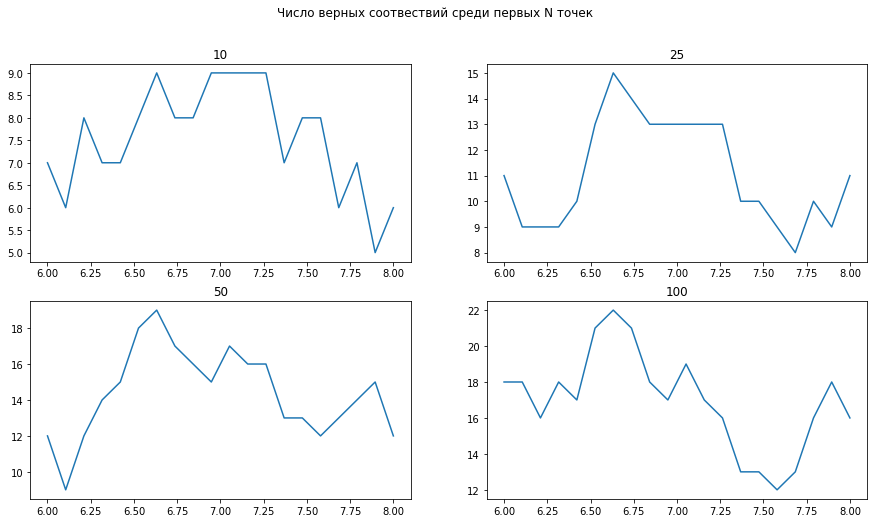

In [232]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 8))

grid = np.linspace(6, 8, 20)

def get(n, grid):
    mist_arr = []
    for sigma in grid:
        mist = get_mist(sigma, n, X, Y)
        mist_arr.append(np.sum(np.array(mist) < 14))
    return mist_arr

axarr[0, 0].plot(grid, get(10, grid))
axarr[0, 0].set_title('10')
axarr[0, 1].plot(grid, get(25, grid))
axarr[0, 1].set_title('25')
axarr[1, 0].plot(grid, get(50, grid))
axarr[1, 0].set_title('50')
axarr[1, 1].plot(grid, get(100, grid))
axarr[1, 1].set_title('100')

fig.suptitle('Число верных соотвествий среди первых N точек')
plt.show()

Ниже все те же вычисления приведены для повернутого на 90 градусов изображения. Сразу скажу, что __почти ничего в статистиках не поменялось__, что вполне ожидаемо, так как SIFT устойчив к поворотам.

In [233]:
X = []
Y = []

img1 = cv.imread('origin.jpg', cv.IMREAD_GRAYSCALE)
l = img1.shape[1]

for i, row in data.iterrows():
    X.append([row['y1'], l - row['x1']])
    Y.append([row['x2'], row['y2']])

X = np.array(X)
Y = np.array(Y)

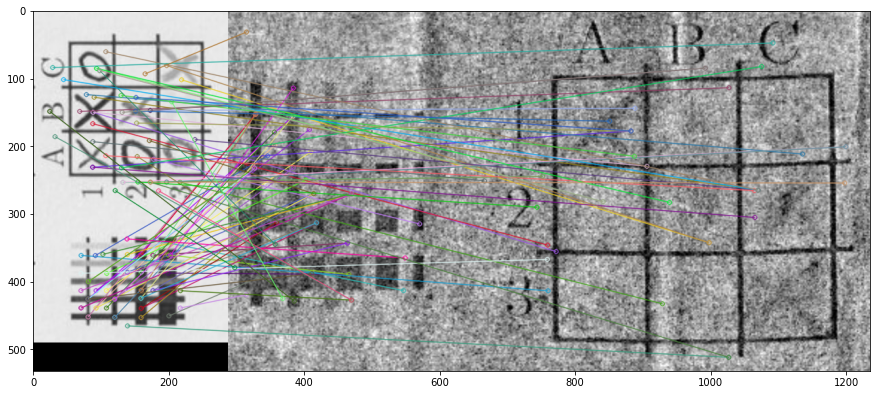

(<matplotlib.image.AxesImage at 0x332646e00>, None)

In [234]:
img1 = cv.imread('rot_origin.jpg', cv.IMREAD_GRAYSCALE)
img2 = 255 - cv.imread('rec.jpg', cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create(sigma=7, nOctaveLayers=2)

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher()

matches = bf.match(des1,des2)

matches = sorted(matches, key = lambda x:x.distance)
pairs = [ (kp1[match.queryIdx].pt, kp2[match.trainIdx].pt) for match in matches ]

N = 100

img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:N],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize =(15, 8)) 
    
plt.imshow(img3),plt.show()